In [1]:
import hisepy
import os
import pandas as pd
import scanpy as sc

In [2]:
def read_adata_uuid(h5ad_uuid):
    h5ad_path = '/home/jupyter/cache/{u}'.format(u = h5ad_uuid)
    if not os.path.isdir(h5ad_path):
        hise_res = hisepy.reader.cache_files([h5ad_uuid])
    h5ad_filename = os.listdir(h5ad_path)[0]
    h5ad_file = '{p}/{f}'.format(p = h5ad_path, f = h5ad_filename)
    adata = sc.read_h5ad(h5ad_file)
    return adata

In [3]:
def read_parquet_uuid(pq_uuid):
    pq_path = '/home/jupyter/cache/{u}'.format(u = pq_uuid)
    if not os.path.isdir(pq_path):
        hise_res = hisepy.reader.cache_files([pq_uuid])
    pq_filename = os.listdir(pq_path)[0]
    pq_file = '{p}/{f}'.format(p = pq_path, f = pq_filename)
    df = pd.read_parquet(pq_file)
    return df

## Read subclustering and barcode annotations from HISE

In [4]:
cell_class = 'myeloid'

In [5]:
h5ad_uuid = 'c38df326-662d-459b-982d-0186c022f70d'

In [6]:
adata = read_adata_uuid(h5ad_uuid)

In [7]:
anno_uuid = 'eff741c2-b0fe-4dff-9914-ff5dc89ee95e'

In [8]:
anno = read_parquet_uuid(anno_uuid)

In [9]:
anno.head()

,barcodes,AIFI_L1,AIFI_L2,AIFI_L3
0,cf71fa1048b611ea8957bafe6d70929e,Monocyte,CD14 monocyte,Core CD14 monocyte
1,cf71ffba48b611ea8957bafe6d70929e,Monocyte,CD14 monocyte,Core CD14 monocyte
2,cf72153648b611ea8957bafe6d70929e,DC,pDC,pDC
3,cf721da648b611ea8957bafe6d70929e,Monocyte,CD14 monocyte,Core CD14 monocyte
4,cf7221e848b611ea8957bafe6d70929e,Monocyte,CD14 monocyte,Core CD14 monocyte


## Add annotations to barcodes

In [10]:
obs = adata.obs
obs = obs.reset_index(drop = True)
obs = obs.merge(anno, on = 'barcodes', how = 'left')
obs = obs.set_index('barcodes', drop = False)

In [11]:
adata.obs = obs

## Drop doublet/contamination labels

In [12]:
exclude_terms = [
    'Contamination', 'contamination',
    'Doublet', 'doublet',
    'Mito', 'mito'
]

In [13]:
all_types = adata.obs['AIFI_L3'].unique().tolist()

In [14]:
exclude_types = []
for cell_type in all_types:
    for term in exclude_terms:
        if term in cell_type:
            exclude_types.append(cell_type)

In [15]:
exclude_types

['Doublet']

In [16]:
keep_types = []
for cell_type in all_types:
    if not cell_type in exclude_types:
        keep_types.append(cell_type)

In [17]:
adata = adata[adata.obs['AIFI_L3'].isin(keep_types)]
adata.shape

(351206, 1112)

## Plot L2 marker expression

In [18]:
l2_markers = [
    'AXL', 'C1orf54', 'CD14', 'CD1C', 'CD74',
    'CDKN1C', 'CLEC9A', 'CST3', 'FCGR3A', 'HLA-DRA',
    'IL3RA', 'IRF8', 'ITM2C', 'PLAC8', 'S100A10',
    'S100A9', 'SIGLEC6', 'SPI1', 'VCAN'
]

Set L2 category order

In [19]:
category_order = [
    'ASDC',
    'pDC',
    'cDC1',
    'cDC2',
    'CD16 monocyte',
    'CD14 monocyte',
    'Intermediate monocyte'
]

adata.obs['AIFI_L2'] = (
    adata.obs['AIFI_L2']
    .cat
    .set_categories(category_order, ordered=True)
)

/tmp/ipykernel_3078/4294707121.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['AIFI_L2'] = (


/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


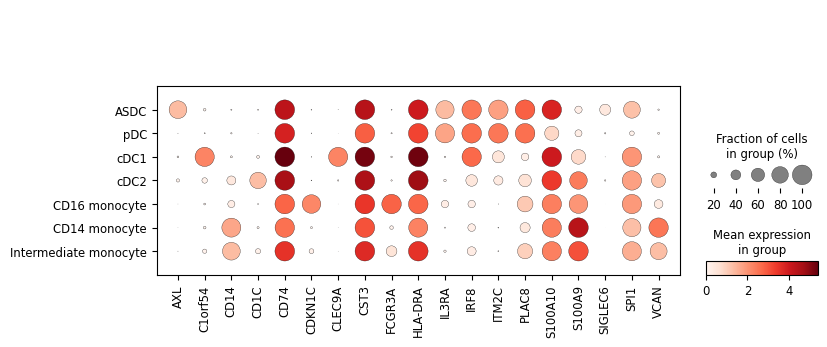

In [20]:
sc.pl.dotplot(
    adata,
    groupby = 'AIFI_L2',
    var_names = l2_markers,
    log = True
)

## Plot L3 marker expression

In [21]:
l3_markers = [
    'AXL', 'C1QA', 'C1QB', 'C1orf54', 'CCL3',
    'CD14', 'CD163', 'CD1C', 'CD68', 'CD74',
    'CLEC9A', 'CST3', 'FCGR3A', 'GAPDH', 'HLA-DPA1',
    'HLA-DRA', 'IFI44L', 'IL1B', 'IL3RA', 'IRF8',
    'ISG15', 'ITM2C', 'MX1', 'NFKBIA', 'PLAC8',
    'S100A10', 'S100A8', 'S100A9', 'SIGLEC6', 'SMIM25',
    'SOD2', 'SPI1', 'VCAN'
]

Set L3 category order

In [22]:
category_order = [
    'ASDC',
    'pDC',
    'cDC1',
    'ISG+ cDC2',
    'CD14+ cDC2',
    'HLA-DRhi cDC2',
    'C1Q+ CD16 monocyte',
    'Core CD16 monocyte',
    'ISG+ CD16 monocyte',
    'IL1B+ CD14 monocyte',
    'Intermediate monocyte',
    'Core CD14 monocyte',
    'ISG+ CD14 monocyte'
]

adata.obs['AIFI_L3'] = (
    adata.obs['AIFI_L3']
    .cat
    .set_categories(category_order, ordered=True)
)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


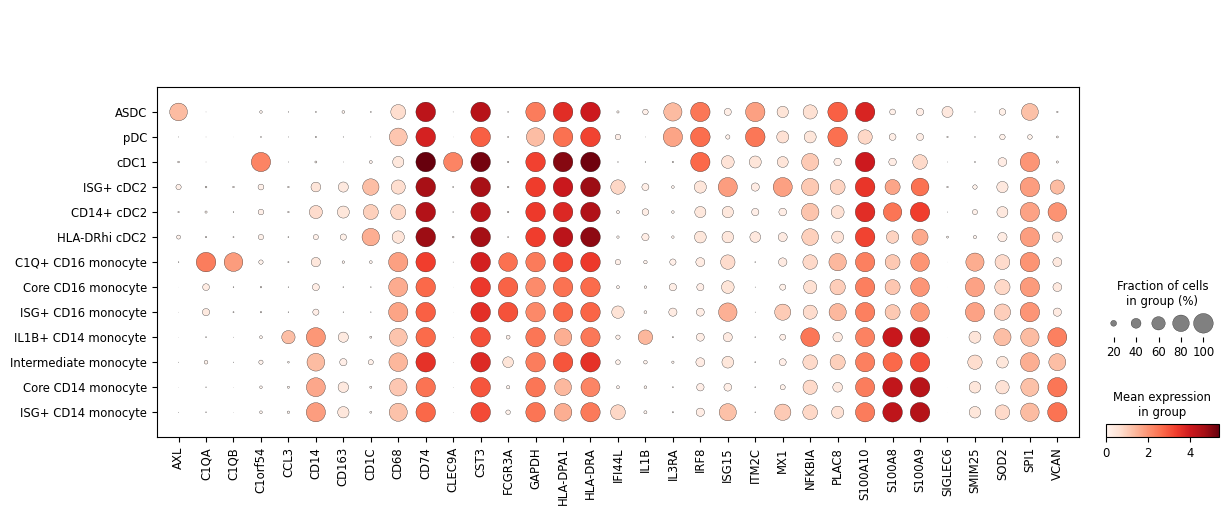

In [23]:
sc.pl.dotplot(
    adata,
    groupby = 'AIFI_L3',
    var_names = l3_markers,
    log = True
)

In [24]:
import session_info
session_info.show()